In [198]:
# General Libs
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [222]:
im_shape = (250,250)

base_dir = './dataset/dataset'
train_dir = './dataset/train'
test_dir = './dataset/test'
TRAINING_DIR = '.\\dataset\\train'
TEST_DIR = '.\\dataset\\test'

seed = 10

EPOCHS = 500
PATIENCE = 60
BATCH_SIZE = 20

In [203]:
# Normalizar os caminhos
base_dir = os.path.normpath(base_dir)
train_dir = os.path.normpath(train_dir)
test_dir = os.path.normpath(test_dir)

# Criação das pastas de treino, validação e teste
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [204]:
# Processamento de todas as imagens nas subpastas
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    folder_path = os.path.normpath(folder_path) 
    
    
    train_dir_aux = os.path.join(train_dir, folder)
    train_dir_aux = os.path.normpath(train_dir_aux)
    
    test_dir_aux = os.path.join(test_dir, folder)
    test_dir_aux = os.path.normpath(test_dir_aux)
    
    os.makedirs(test_dir_aux, exist_ok=True)
    os.makedirs(train_dir_aux, exist_ok=True)
    
    
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        
        # Divide em treino (70%), teste (30%)
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
        
        # Mover imagens de treino
        for image_file in train_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(train_dir_aux, image_file))
        
        # Mover imagens de teste
        for image_file in test_images:
            shutil.copy(os.path.join(folder_path, image_file), os.path.join(test_dir_aux, image_file))

print("Processo de divisão e aumento de dados completo!")

Processo de divisão e aumento de dados completo!


In [205]:
def verify_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Tenta abrir o arquivo como imagem
                img.verify()  # Verifica se é uma imagem válida
            except (IOError, SyntaxError) as e:
                print(f"Arquivo inválido detectado: {file_path}, erro: {e}")

# Verificar imagens no diretório de treino
verify_images(TRAINING_DIR)

# Verificar imagens no diretório de teste
verify_images(TEST_DIR)

In [207]:
data_generator = ImageDataGenerator(
        validation_split=0.3,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.6,
        horizontal_flip=True,
        brightness_range=[0.5, 1.0],
        channel_shift_range=150.0,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [208]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 107 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Classes: ['bola', 'celular', 'coelho']


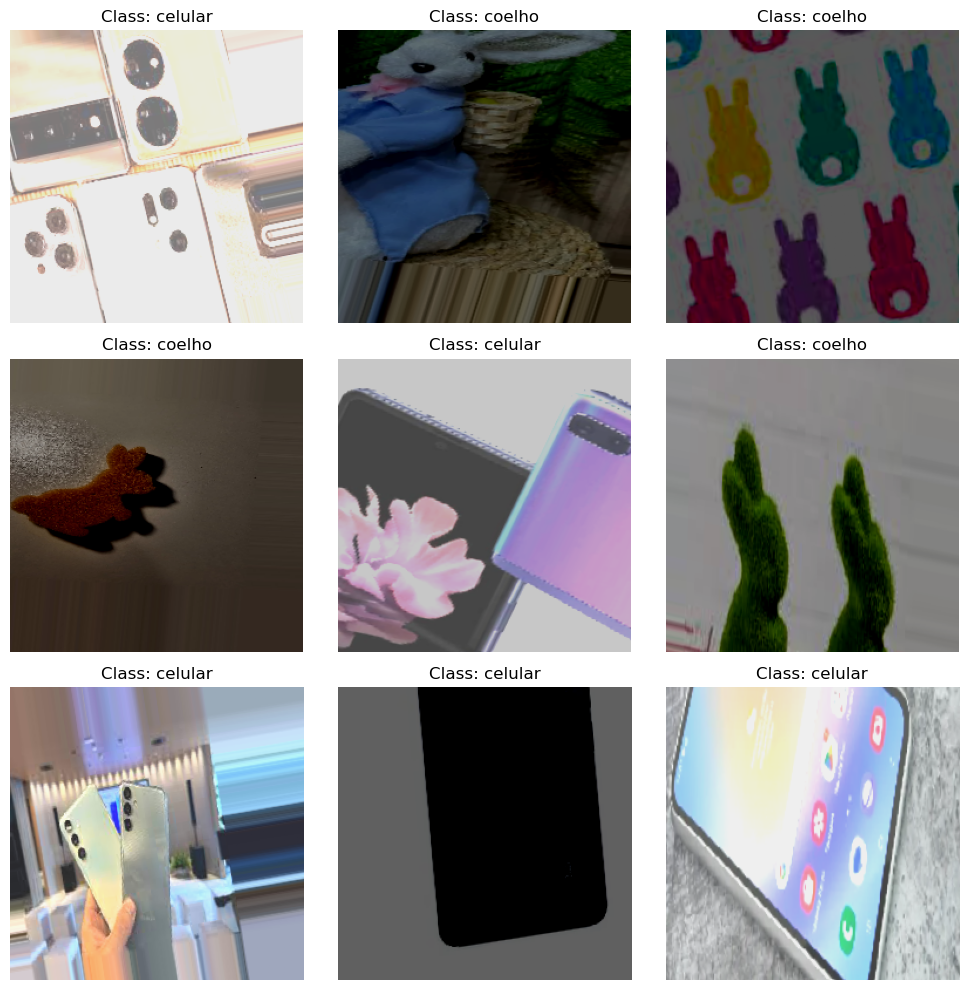

In [210]:
images, labels = next(train_generator)
    
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(f'Class: {classes[label]}')  # Exibir a classe binária (0 ou 1)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [236]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
  

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 248, 248, 128)     3584      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 124, 124, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 122, 122, 64)      73792     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 29, 29, 64)     

In [237]:
#Callback to save the best model 
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.tf',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE,verbose=1)
]

#Training
history = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // BATCH_SIZE,
            epochs=EPOCHS,
            callbacks = callbacks_list,
            validation_data=validation_generator,
            verbose = 1,
            validation_steps=nb_validation_samples // BATCH_SIZE
        )

Epoch 1/500


e:\programming\anaconda3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.2991
Epoch 1: val_loss improved from inf to 1.09858, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


5/5 [==============================] - 9s 2s/step - loss: 1.1174 - accuracy: 0.2991 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/500
3/5 [=================>............] - ETA: 0s - loss: 1.1076 - accuracy: 0.3158

e:\programming\anaconda3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 [==============================] - ETA: 0s - loss: 1.1061 - accuracy: 0.3458
Epoch 2: val_loss improved from 1.09858 to 1.09633, saving model to model.tf


INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


5/5 [==============================] - 8s 2s/step - loss: 1.1061 - accuracy: 0.3458 - val_loss: 1.0963 - val_accuracy: 0.3333
Epoch 3/500
4/5 [=======================>......] - ETA: 0s - loss: 1.1042 - accuracy: 0.3415

e:\programming\anaconda3\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.3084
Epoch 3: val_loss did not improve from 1.09633
5/5 [==============================] - 4s 762ms/step - loss: 1.1056 - accuracy: 0.3084 - val_loss: 1.0978 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.3271
Epoch 4: val_loss did not improve from 1.09633
5/5 [==============================] - 4s 728ms/step - loss: 1.1029 - accuracy: 0.3271 - val_loss: 1.0981 - val_accuracy: 0.3333
Epoch 5/500
5/5 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.3832
Epoch 5: val_loss did not improve from 1.09633
5/5 [==============================] - 4s 915ms/step - loss: 1.1002 - accuracy: 0.3832 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 6/500
5/5 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3084
Epoch 6: val_loss did not improve from 1.09633
5/5 [==============================] - 4s 715ms/step - loss: 1.09

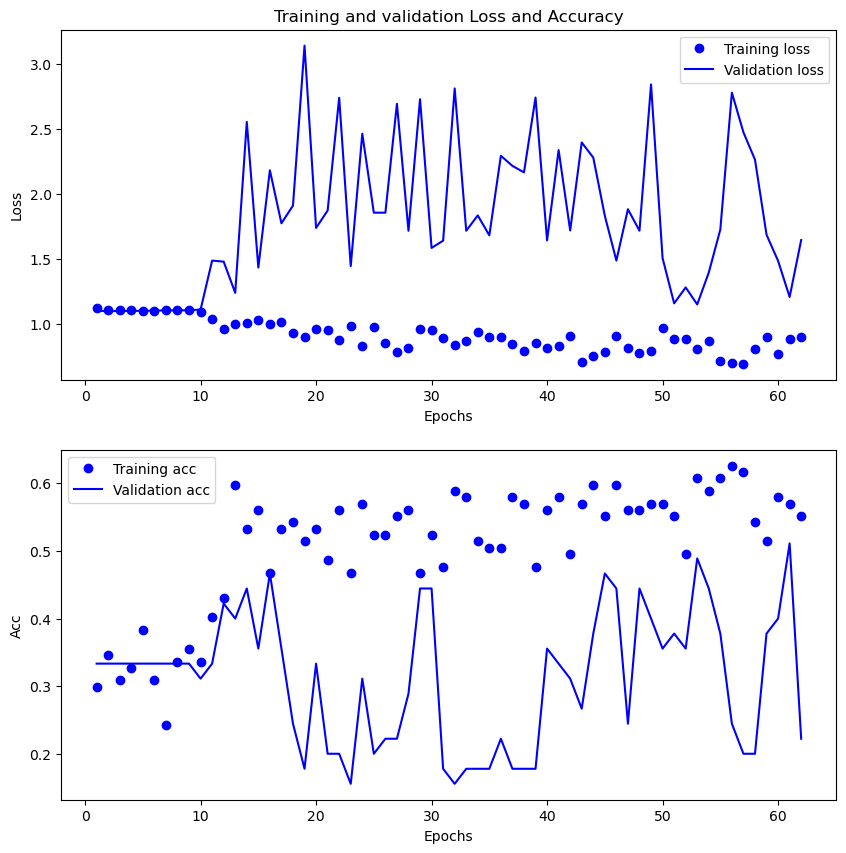

In [238]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Evaluating the model

In [239]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.tf')

In [241]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

2/2 [==============================] - 1s 23ms/step - loss: 1.0963 - accuracy: 0.3333
Val loss: 1.0963292121887207
Val accuracy: 0.3333333432674408


In [242]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 1s 174ms/step - loss: 1.0990 - accuracy: 0.3333
Test loss: 1.0989869832992554
Test accuracy: 0.3333333432674408


In [243]:
labels_prediction = list(test_generator.class_indices.keys())
labels_prediction

['bola', 'celular', 'coelho']

3/3 [==============================] - 1s 325ms/step
Classification Report
              precision    recall  f1-score   support

        bola       0.00      0.00      0.00        22
     celular       0.00      0.00      0.00        22
      coelho       0.33      1.00      0.50        22

    accuracy                           0.33        66
   macro avg       0.11      0.33      0.17        66
weighted avg       0.11      0.33      0.17        66



e:\programming\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\programming\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\programming\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


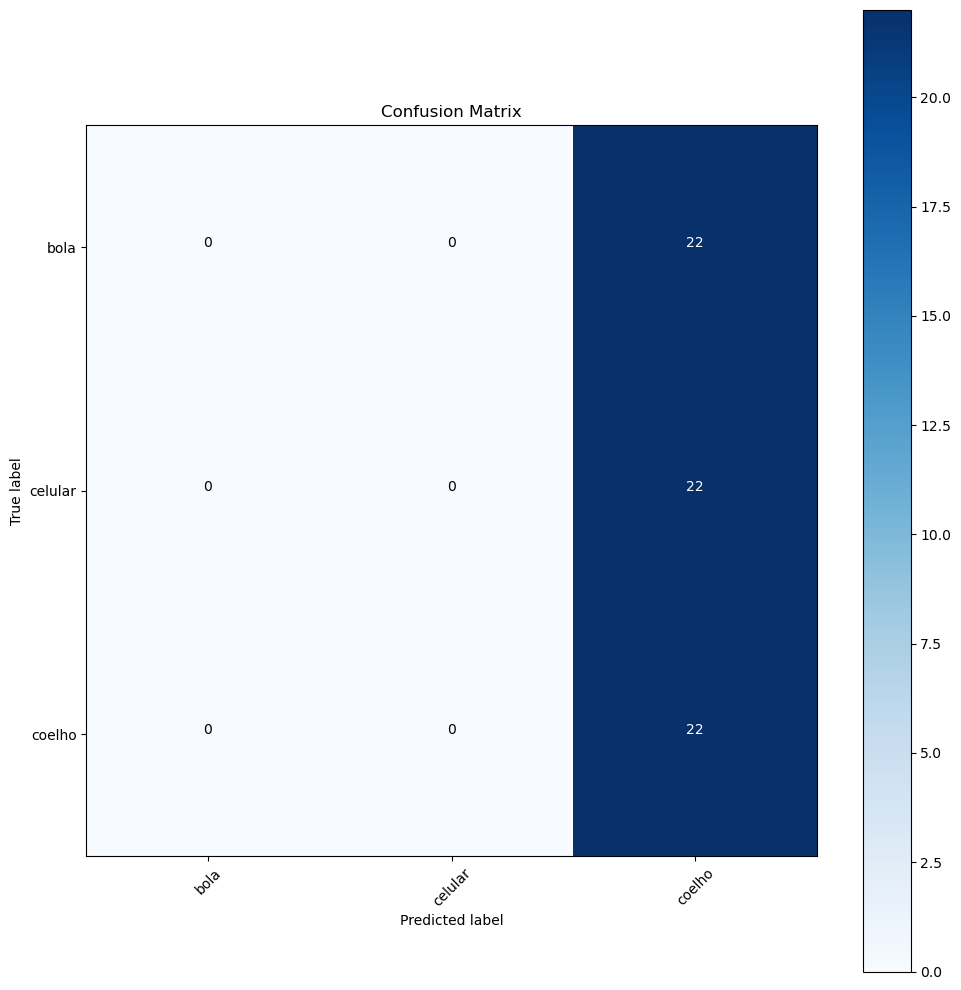

In [244]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
#On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [233]:
# Parâmetros
input_shape = im_shape

# Iniciar a captura da câmera
cap = cv2.VideoCapture(0)  # '0' geralmente é a câmera padrão. Pode ser ajustado para outra fonte.

while True:
    # Captura frame a frame
    ret, frame = cap.read()
    if not ret:
        break

    # Pre-processamento da imagem
    img = cv2.resize(frame, input_shape)
    img = img.astype('float32') / 255.0  # Normaliza para 0-1
    img = np.expand_dims(img, axis=0)    # Adiciona dimensão de lote (batch)

    # Fazer previsão com o modelo
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)

    # Exibir o resultado no frame
    cv2.putText(frame, f'Class: {labels_prediction[predicted_class[0]]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Exibir o frame
    cv2.imshow('Camera', frame)

    # Sair com a tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libere a captura e feche as janelas
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step
